In [38]:
# !pip install catboost
# !pip install shap
# !pip install h3
# !pip install ipyleaflet
# !pip install ipywidgets
# !pip install boruta
# !pip install HeatMap

С 1934 по 1963 год Сан-Франциско был печально известен тем, что на неизбежном острове Алькатрас жили одни из самых известных преступников мира.

Сегодня город больше известен своей технологической сценой, чем своим криминальным прошлым. Но с растущим имущественным неравенством, нехваткой жилья и распространением дорогих цифровых игрушек, использующих BART на работу, в городе у залива нет недостатка в преступности.

От Sunset до SOMA и от Marina до Excelsior, набор данных этого конкурса содержит отчеты о преступлениях почти за 12 лет со всех районов Сан-Франциско. Учитывая время и место, вы должны предсказать категорию совершенного преступления.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import shap
import missingno as msno
import h3
import folium
from boruta import BorutaPy
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, train_test_split
from IPython.core.pylabtools import figsize

color = sns.color_palette()
%matplotlib inline
warnings.filterwarnings("ignore")

In [40]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GP2/train.csv')


In [42]:
df_train.head(10)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601
9,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802


In [43]:
print(df_train.duplicated().sum())


2323


In [44]:
df_train.drop_duplicates(inplace=True)

In [45]:
# Визуализируем пропущенные значения в виде матрицы
# figsize(5, 5)
# msno.bar(df_train)
display(df_train.isna().sum())

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [46]:
df_train.describe()

,X,Y
count,875726.000000,875726.000000
mean,-122.422623,37.771032
std,0.030363,0.457497
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416446,37.775421
75%,-122.406959,37.784380
max,-120.500000,90.000000


In [47]:
df_train.query('X==-120.5 and Y==90').count()

Dates         67
Category      67
Descript      67
DayOfWeek     67
PdDistrict    67
Resolution    67
Address       67
X             67
Y             67
dtype: int64

In [48]:
df_train.loc[df_train["Y"] == 90, "Y"] = df_train[df_train["Y"] < 90]["Y"].median()
df_train.loc[df_train["X"] == -120.5, "X"] = df_train[df_train["X"] < -120.5]["X"].median()
df_train.describe()

,X,Y
count,875726.000000,875726.000000
mean,-122.422770,37.767037
std,0.025280,0.024165
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416446,37.775421
75%,-122.406959,37.784371
max,-122.364937,37.819975


In [49]:
df_train

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


Category
LARCENY/THEFT     174320
OTHER OFFENSES    125960
NON-CRIMINAL       91915
ASSAULT            76815
DRUG/NARCOTIC      53919
VEHICLE THEFT      53706
VANDALISM          44581
WARRANTS           42145
BURGLARY           36600
SUSPICIOUS OCC     31394
Name: Category, dtype: int64

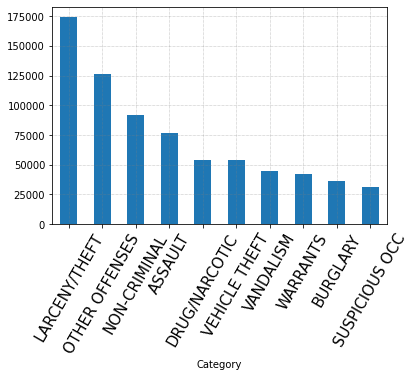

In [50]:
category = df_train.groupby('Category')['Category'].count()
top_category = category.nlargest(10)
top_category_plot = top_category.plot.bar()

plt.xticks(rotation=90)
ax = plt.gca()
ax.grid(True, color = "grey", 
            linewidth = "0.5", 
            alpha = 10, 
            linestyle = ':')
# plt.title('Распределение ')
# plt.ylabel('количество проишествий');
plt.rcParams['figure.figsize'] = (10,10)
plt.xticks(rotation=60,fontsize=15)
plt.savefig('123.png', bbox_inches='tight')
category.nlargest(10)




Address
800 Block of BRYANT ST          26245
800 Block of MARKET ST           6576
2000 Block of MISSION ST         5094
1000 Block of POTRERO AV         4046
900 Block of MARKET ST           3245
0 Block of TURK ST               3224
0 Block of 6TH ST                2882
300 Block of ELLIS ST            2701
400 Block of ELLIS ST            2584
16TH ST / MISSION ST             2501
1000 Block of MARKET ST          2487
1100 Block of MARKET ST          2315
2000 Block of MARKET ST          2166
100 Block of OFARRELL ST         2135
700 Block of MARKET ST           2075
3200 Block of 20TH AV            2030
100 Block of 6TH ST              1886
500 Block of JOHNFKENNEDY DR     1812
TURK ST / TAYLOR ST              1810
200 Block of TURK ST             1796
Name: Address, dtype: int64

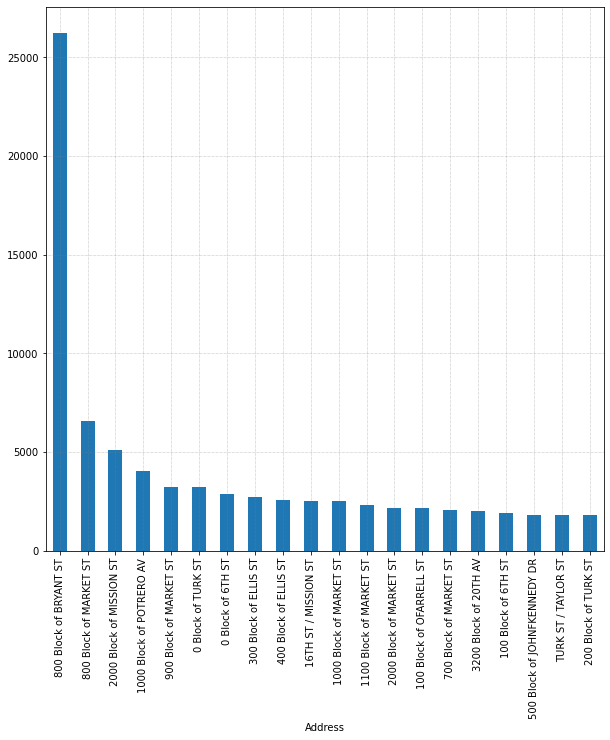

In [51]:
address = df_train.groupby('Address')['Address'].count()
top_address = address.nlargest(20)
top_address_plot = top_address.plot.bar()

plt.xticks(rotation=90)
ax = plt.gca()
ax.grid(True, color = "grey", 
            linewidth = "0.5", 
            alpha = 10, 
            linestyle = ':')

plt.rcParams['figure.figsize'] = (10,10)
address.nlargest(20)

In [52]:
block = df_train.loc[df_train.Address.str.contains('Block')]['Address'].count()
not_block = df_train.loc[~df_train.Address.str.contains('Block')]['Address'].count()
display(block,
        not_block)

615322

260404

In [53]:
from ipywidgets import HTML
from ipyleaflet import Map, Marker, Popup
from ipywidgets import Layout

points = []
i = 0
for i in range(len(top_address)):
  points.append([df_train[df_train.Address==top_address.index[i]]['Y'].mean(), df_train[df_train.Address==top_address.index[i]]['X'].mean()])
points


# points.append([df_train['Y'].min(), df_train['X'].max()])
# points.append([df_train['Y'].max(), df_train['X'].max()])
# points.append([df_train['Y'].min(), df_train['X'].min()])
# points.append([df_train['Y'].max(), df_train['X'].min()])
# points.append([df_train['Y'].mean(), df_train['X'].mean()])

m = Map(center=(df_train["Y"].mean(), df_train["X"].mean()), zoom=12,
    layout=Layout(width='50%', height='500px'))

i = 0
while i < len(points):
  m.add_layer(Marker(location=(points[i])))
  i += 1
m  

Map(center=[37.76703673513809, -122.42276966430363], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [54]:
df_train["Dates"] = pd.to_datetime(df_train["Dates"])
df_train["YEAR"] = df_train["Dates"].dt.year
df_train["MONTH"] = df_train["Dates"].dt.month
# df_train["DAY"] = df_train["Dates"].dt.day
df_train["HOUR"] = df_train["Dates"].dt.hour


df_train['IsDay'] = 0 
df_train.loc[(df_train.Dates.dt.hour > 5) & (df_train.Dates.dt.hour < 21), 'IsDay' ] = 1 
   
df_train.drop("Dates", axis=1, inplace=True)

# На блоке - так называют место, где люди слоняются без дела, продаются наркотики и которое постоянно посещают полицейские.
df_train['Block_crit'] = 1 
df_train.loc[df_train.Address.str.contains('Block'), 'Block_crit'] = 0

df_train


,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YEAR,MONTH,HOUR,IsDay,Block_crit
0,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,23,0,1
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,23,0,1
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,23,0,1
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,23,0,0
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,23,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003,1,0,0,1
878045,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,2003,1,0,0,0
878046,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,2003,1,0,0,1
878047,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003,1,0,0,1


In [55]:
def visualize_hexagons(hexagons, color="red", folium_map=None):

    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
        
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)

    return m
  
h3_address1 = h3.geo_to_h3(37.774599, -122.425892,7) # 7 - индекс, определяющий размер гексагона    
h3_address2 = h3.geo_to_h3(37.7, -122.425892,7) # 7 - индекс, определяющий размер гексагона      
h3_address3 = h3.geo_to_h3(37.7, -122.4,7) # 7 - индекс, определяющий размер гексагона                                                                                              
visualize_hexagons([h3_address1,h3_address2,h3_address3])

In [56]:
# df_train['hexagons'] = h3.geo_to_h3(df_train['Y'], df_train['X'], 9)

# def hex_indexer(row):
#   x = row.X
#   y = row.Y
#   level = 7
#   hex_val = h3.geo_to_h3(x, y, level)
#   return hex_val


# df_train['H3_Index'] = df_train.apply(hex_indexer, axis=1)
# df_train=df_train.drop(['X'], axis=1)
# df_train=df_train.drop(['Y'], axis=1)
df_train


,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YEAR,MONTH,HOUR,IsDay,Block_crit
0,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,23,0,1
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,23,0,1
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,23,0,1
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,23,0,0
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,23,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003,1,0,0,1
878045,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,2003,1,0,0,0
878046,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,2003,1,0,0,1
878047,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003,1,0,0,1


In [57]:
categorical_features=['DayOfWeek','Resolution','Address','PdDistrict']


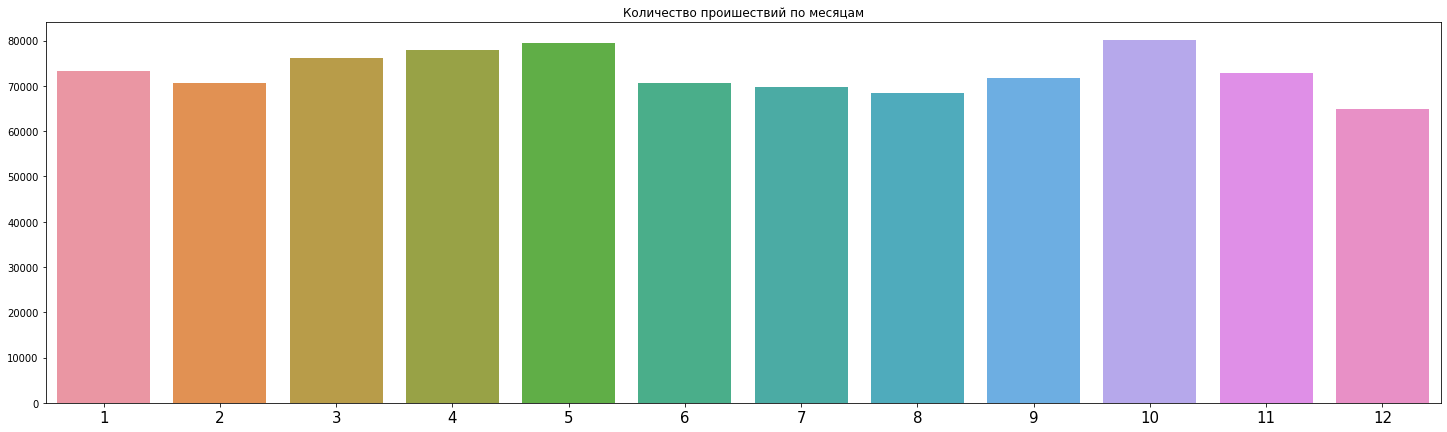

In [58]:
df = pd.DataFrame(df_train.groupby('MONTH')['Category'].count())
df.reset_index(inplace=True)
figsize(25, 7)
sns.barplot(x = df['MONTH'],
            y = df['Category'],
            data = df)
plt.xticks(fontsize=15)
plt.title('Количество проишествий по месяцам')
plt.xlabel('');
plt.ylabel('');

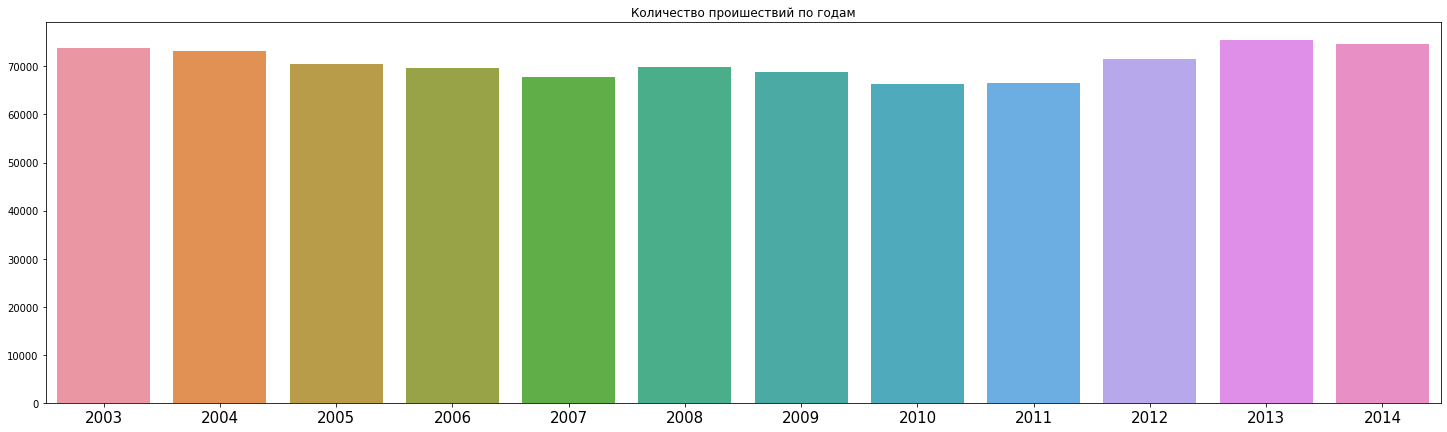

In [59]:
df = pd.DataFrame(df_train.groupby('YEAR')['Category'].count())
df.reset_index(inplace=True)
df.query('YEAR<2015')

figsize(25, 7)
sns.barplot(x = df.query('YEAR<2015')['YEAR'],
            y = df.query('YEAR<2015')['Category'],
            data = df.query('YEAR<2015'))
plt.xticks(fontsize=15)
plt.title('Количество проишествий по годам')
plt.xlabel('');
plt.ylabel('');

In [62]:
df = pd.DataFrame(df_train.groupby('DayOfWeek')['Category'].count())
df.reset_index(inplace=True)
# df.sort_values('Category', ascending = False, inplace= True)
df

,DayOfWeek,Category
0,Friday,133371
1,Monday,121303
2,Saturday,126469
3,Sunday,116394
4,Thursday,124757
5,Tuesday,124603
6,Wednesday,128829


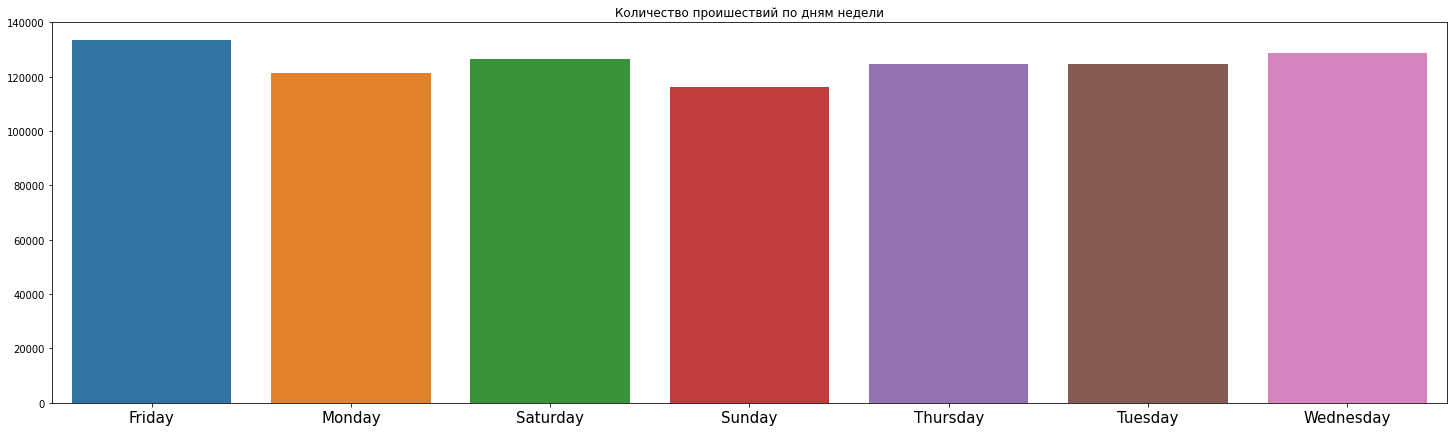

In [63]:
figsize(25, 7)
sns.barplot(x = df['DayOfWeek'],
            y = df['Category'],
            data = df)
plt.xticks(fontsize=15)
plt.title('Количество проишествий по дням недели')
plt.xlabel('');
plt.ylabel('');
plt.savefig('график.png', bbox_inches='tight')
# plt.xticks([0, 1, 2,3,4,5,6,7], ['пятница','United Airlines, Inc.','Delta Air Lines, Inc.','British Airways p.l.c.','Continental Airlines'],
        # rotation=70) 

In [ ]:

X = df_train.drop(['Category','Resolution','Descript'], axis=1)
y = df_train.Category
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)
X_train

,DayOfWeek,PdDistrict,Address,X,Y,YEAR,MONTH,HOUR,IsDay,Block_crit
306721,Wednesday,SOUTHERN,800 Block of BRYANT ST,-122.403405,37.775421,2011,2,15,1,0
718234,Thursday,MISSION,DOLORES ST / 25TH ST,-122.425001,37.750234,2005,3,22,0,1
70643,Monday,BAYVIEW,SAN BRUNO AV / FELTON ST,-122.404594,37.730038,2014,6,23,0,1
606827,Wednesday,CENTRAL,1100 Block of HYDE ST,-122.417557,37.791448,2006,10,18,1,0
99138,Tuesday,SOUTHERN,1600 Block of MISSION ST,-122.419231,37.772033,2014,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
259825,Saturday,SOUTHERN,NATOMA ST / 7TH ST,-122.409939,37.778415,2011,11,18,1,1
366764,Wednesday,TENDERLOIN,EDDY ST / TAYLOR ST,-122.410955,37.784140,2010,4,13,1,1
132293,Saturday,SOUTHERN,800 Block of BRYANT ST,-122.403405,37.775421,2013,8,2,0,0
672955,Monday,RICHMOND,500 Block of JOHNFKENNEDY DR,-122.466205,37.772541,2005,10,8,1,0


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GP2/test.csv')

df_test["Dates"] = pd.to_datetime(df_test["Dates"])
df_test["YEAR"] = df_test["Dates"].dt.year
df_test["MONTH"] = df_test["Dates"].dt.month
# df_test["DAY"] = df_test["Dates"].dt.day
df_test["HOUR"] = df_test["Dates"].dt.hour
# df_test["MINUTE"] = df_test["Dates"].dt.minute
df_test['IsDay'] = 0 
df_test.loc[ (df_test.Dates.dt.hour > 5) & (df_test.Dates.dt.hour < 21), 'IsDay' ] = 1
df_test=df_test.drop(['Dates'], axis=1)

test_ID = df_test["Id"]
df_test.drop("Id", axis=1, inplace=True)

df_test['Block_crit'] = 1 
df_test.loc[df_test.Address.str.contains('Block'), 'Block_crit'] = 0

# df_test['H3_Index'] = df_test.apply(hex_indexer, axis=1)
# df_test=df_test.drop(['X'], axis=1)
# df_test=df_test.drop(['Y'], axis=1)

df_test

,DayOfWeek,PdDistrict,Address,X,Y,YEAR,MONTH,HOUR,IsDay,Block_crit
0,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,23,0,0
1,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,23,0,1
2,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,23,0,0
3,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,23,0,0
4,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,23,0,0
...,...,...,...,...,...,...,...,...,...,...
884257,Wednesday,MISSION,2600 Block of BRYANT ST,-122.408983,37.751987,2003,1,0,0,0
884258,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.425342,37.792681,2003,1,0,0,0
884259,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075,2003,1,0,0,0
884260,Wednesday,BAYVIEW,1500 Block of HUDSON AV,-122.387394,37.739479,2003,1,0,0,0


In [ ]:
categorical_features=['DayOfWeek','Address','PdDistrict']

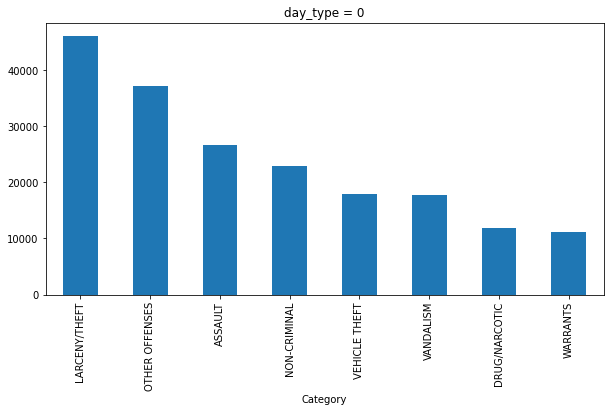

Category
LARCENY/THEFT     46149
OTHER OFFENSES    37167
ASSAULT           26641
NON-CRIMINAL      22843
VEHICLE THEFT     17870
VANDALISM         17679
DRUG/NARCOTIC     11816
WARRANTS          11109
Name: Category, dtype: int64


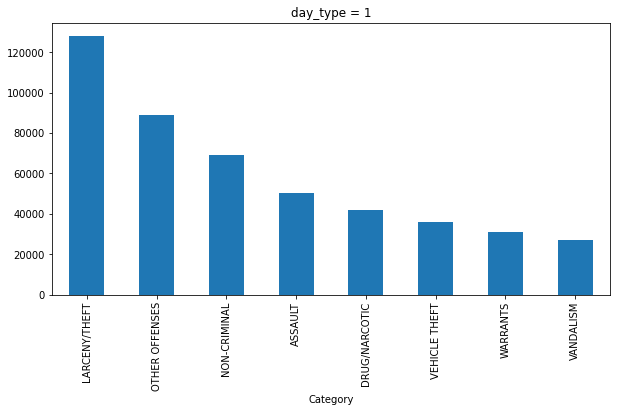

Category
LARCENY/THEFT     128171
OTHER OFFENSES     88793
NON-CRIMINAL       69072
ASSAULT            50174
DRUG/NARCOTIC      42103
VEHICLE THEFT      35836
WARRANTS           31036
VANDALISM          26902
Name: Category, dtype: int64


In [ ]:
for i in range (0,1+1):
  day_type = df_train.loc[(df_train['IsDay']==i)].groupby('Category')['Category'].count().sort_values().nlargest(8)
  day_type.plot(kind='bar', 
         figsize=(10,5), 
         title = f'day_type = {i}')
  plt.show()
  print(day_type)

In [ ]:

model = CatBoostClassifier(n_estimators=6000, 
                           learning_rate=0.05,
                           cat_features=categorical_features,
                           random_seed=42, 
                           early_stopping_rounds=2000,
                           task_type="GPU", 
                           verbose=100)

model.fit(X,y)

0:	learn: 3.4860870	total: 869ms	remaining: 1h 26m 55s
100:	learn: 2.4189612	total: 1m 18s	remaining: 1h 16m 32s
200:	learn: 2.3844433	total: 2m 34s	remaining: 1h 14m 20s
300:	learn: 2.3650460	total: 3m 50s	remaining: 1h 12m 50s
400:	learn: 2.3507545	total: 5m 6s	remaining: 1h 11m 26s
500:	learn: 2.3394969	total: 6m 23s	remaining: 1h 10m 8s
600:	learn: 2.3304447	total: 7m 39s	remaining: 1h 8m 46s
700:	learn: 2.3227474	total: 8m 55s	remaining: 1h 7m 28s
800:	learn: 2.3157858	total: 10m 11s	remaining: 1h 6m 8s
900:	learn: 2.3090801	total: 11m 27s	remaining: 1h 4m 50s
1000:	learn: 2.3033757	total: 12m 43s	remaining: 1h 3m 32s
1100:	learn: 2.2978219	total: 13m 59s	remaining: 1h 2m 14s
1200:	learn: 2.2929270	total: 15m 14s	remaining: 1h 56s
1300:	learn: 2.2880469	total: 16m 30s	remaining: 59m 39s
1400:	learn: 2.2835205	total: 17m 46s	remaining: 58m 21s
1500:	learn: 2.2789286	total: 19m 2s	remaining: 57m 5s
1600:	learn: 2.2743933	total: 20m 18s	remaining: 55m 48s
1700:	learn: 2.2699736	total

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(y)
print(le.classes_)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

X[categorical_features]=X[categorical_features].apply(le.fit_transform)

X_boruta = X.values
y_boruta = y

rf = RandomForestClassifier(n_jobs=-1, 
                            n_estimators=1000, 
                            oob_score=True, 
                            max_depth=6)

feat_selector = BorutaPy(rf, 
                         n_estimators='auto', 
                         verbose=2, 
                         random_state=666)

feat_selector.fit(X_boruta, y_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	0


BorutaPy(estimator=RandomForestClassifier(max_depth=6, n_estimators=74,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7F398CD507C0),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F398CD507C0, verbose=2)

In [ ]:
np.shape(feat_selector.ranking_)

(10,)

In [ ]:
model.save_model('HW_2_catboost.model')
# from_file = CatBoostClassifier(task_type = 'GPU') 
# model = from_file.load_model('/content/drive/MyDrive/Colab Notebooks/GP2/HW_2_catboost.model')

In [ ]:
prob = model.predict_proba(df_test)

In [ ]:
pd.DataFrame(prob)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,0.000346,0.144884,8.451690e-07,3.816931e-05,0.043718,0.000516,0.002696,0.009346,0.000440,0.000133,2.905323e-06,4.221878e-06,0.000218,0.003849,4.055981e-07,0.004244,0.123904,0.000014,0.000001,0.012652,0.095102,0.101701,1.736477e-07,1.088795e-05,5.252910e-06,0.037582,0.000037,0.022312,0.001440,6.044272e-05,0.002268,3.393902e-05,0.059133,8.584300e-08,0.004583,0.054471,0.205733,0.012517,0.056003
1,0.000045,0.038504,2.092283e-06,2.954681e-06,0.000557,0.000127,0.028602,0.063421,0.003024,0.000032,4.924974e-07,5.484719e-07,0.000241,0.002941,2.207603e-04,0.000843,0.013739,0.000859,0.000086,0.003525,0.029276,0.532143,1.999778e-08,6.318977e-07,1.055483e-05,0.051691,0.000013,0.005057,0.000144,8.286787e-07,0.006015,1.330637e-05,0.040114,1.752816e-07,0.000024,0.016728,0.045027,0.061228,0.055740
2,0.005900,0.095087,1.765713e-06,1.846633e-06,0.116660,0.000438,0.000071,0.007532,0.002735,0.000006,8.913143e-06,3.174473e-06,0.001154,0.001885,2.412757e-07,0.006745,0.399316,0.000039,0.000001,0.006648,0.039189,0.048614,1.547765e-07,4.690664e-05,5.655454e-07,0.011207,0.000213,0.008331,0.004026,2.049048e-06,0.005895,4.934110e-06,0.025695,3.518526e-08,0.014733,0.081946,0.101530,0.012722,0.001612
3,0.001568,0.217558,2.807064e-06,2.878910e-05,0.010848,0.001710,0.000246,0.079980,0.009130,0.000090,1.785923e-05,6.393744e-04,0.001557,0.017160,2.336708e-04,0.001378,0.063401,0.005222,0.001711,0.010242,0.045597,0.124718,1.883092e-07,4.697277e-04,1.412921e-05,0.031592,0.000658,0.009640,0.025591,3.247423e-05,0.006296,7.170119e-07,0.073683,5.475374e-07,0.001623,0.090296,0.062765,0.065168,0.039131
4,0.001568,0.217558,2.807064e-06,2.878910e-05,0.010848,0.001710,0.000246,0.079980,0.009130,0.000090,1.785923e-05,6.393744e-04,0.001557,0.017160,2.336708e-04,0.001378,0.063401,0.005222,0.001711,0.010242,0.045597,0.124718,1.883092e-07,4.697277e-04,1.412921e-05,0.031592,0.000658,0.009640,0.025591,3.247423e-05,0.006296,7.170119e-07,0.073683,5.475374e-07,0.001623,0.090296,0.062765,0.065168,0.039131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,0.001680,0.117410,4.568808e-04,6.257837e-05,0.061226,0.002832,0.002278,0.059075,0.006462,0.003371,1.129407e-05,4.583456e-04,0.128406,0.025116,6.623407e-05,0.000482,0.084947,0.000524,0.000161,0.009542,0.057406,0.104022,2.677673e-08,4.189744e-05,4.144558e-07,0.013227,0.002616,0.016055,0.032106,2.080723e-05,0.008299,3.295949e-04,0.062763,3.007169e-08,0.014912,0.079716,0.057763,0.041191,0.004965
884258,0.000455,0.090920,1.235356e-02,1.297967e-07,0.111428,0.015585,0.001664,0.030046,0.004918,0.004895,1.795186e-05,4.409522e-05,0.079460,0.032058,2.716802e-06,0.000326,0.185137,0.000058,0.002942,0.019995,0.057945,0.105695,5.415393e-08,1.214226e-03,1.147423e-06,0.009535,0.000024,0.006210,0.010231,1.115917e-06,0.014683,1.878204e-05,0.032948,9.293890e-08,0.005487,0.049237,0.070129,0.042677,0.001659
884259,0.003629,0.138171,4.386412e-04,9.321752e-06,0.027944,0.000468,0.000037,0.165284,0.000562,0.001778,1.217401e-04,1.159088e-04,0.049834,0.031138,5.607749e-06,0.000054,0.036666,0.000066,0.000033,0.004727,0.054850,0.159681,2.858924e-08,1.144528e-03,3.005047e-06,0.008929,0.000169,0.012546,0.020485,4.101155e-04,0.004576,2.062671e-03,0.017971,9.222656e-08,0.007187,0.029025,0.135504,0.082091,0.002284
884260,0.018174,0.201933,9.840578e-04,3.429311e-05,0.022408,0.008021,0.000082,0.045636,0.004076,0.001670,5.699099e-06,1.638124e-04,0.142681,0.029677,3.232275e-05,0.000585,0.082343,0.000006,0.000143,0.004406,0.057302,0.142937,1.100486e-08,1.292197e-05,9.399464e-07,0.004689,0.000069,0.009406,0.004664,1.686224e-03,0.003509,3.799122e-04,0.052055,4.225906e-08,0.002248,0.068859,0.042915,0.040878,0.005329


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(y)


In [ ]:
from datetime import datetime
submission = pd.DataFrame(np.c_[test_ID, prob], columns=['Id'] + list(le.classes_))
submission['Id'] = submission['Id'].astype(int)
submission.to_csv('submission_Group_5 '+str(datetime.now())+' .csv', index=False)


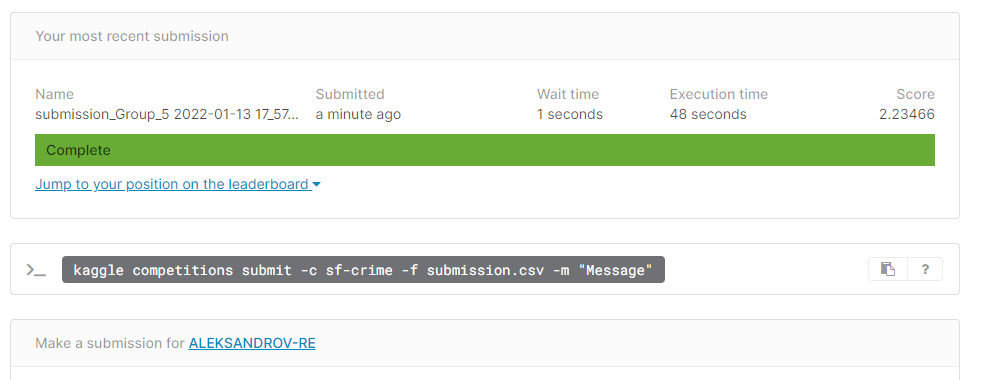

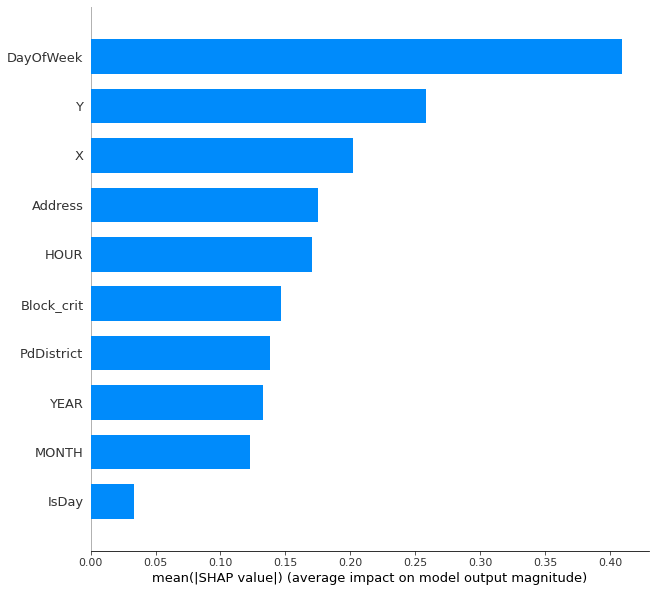

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X.sample(100))
shap.summary_plot(shap_values[1], 
                  X.sample(100), 
                  plot_type= 'bar',
                  class_names = le.classes_,
                  plot_size = (10,10))

In [ ]:
from folium import plugins
from folium.plugins import HeatMap
def query_heat_map(query, location=[37.774599, -122.425892]):
    train_query = df_train.query(query).loc[:, ['Y', 'X']]
    if train_query.shape[0] == 0:
        print('Either the query is failing or there is no data itself.')
    m = folium.Map(location=location, zoom_start=13, tiles='CartoDB dark_matter') # HeatmapPlot-tiles : cartodbdark_matter
    train_query_geo_list = train_query.values.tolist()
    HeatMap(train_query_geo_list, blur=2, radius=3).add_to(m)
    #m.save('SanFrancisco-Crime-geo.html') # add 
    return m

In [ ]:
query_heat_map("Category=='ASSAULT' & Resolution=='ARREST, BOOKED'")